## Import Modules

In [51]:
import os
import re
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io as sio
import seaborn as sns
from tqdm import tqdm
from scipy import stats
from scipy.stats import f_oneway, kruskal
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)     # ignore warnings for specific matplotlib commands which will be outdated soon
warnings.simplefilter(action='ignore', category=FutureWarning)

## Define functions

In [41]:
def convert_to_code_path(windows_path):
    """
    Converts a Windows file path with single backslashes to a format with double backslashes for use in Python code.

    Parameters:
    - windows_path: str
        The original Windows file path (e.g., 'C:\\Users\\YourName\\Folder').

    Returns:
    - str
        The modified path with double backslashes, suitable for Python (e.g., 'C:\\\\Users\\\\YourName\\\\Folder').
    """
    # Replace each single backslash with a double backslash
    return windows_path.replace("\\", "\\\\")



def extract_numeric(value):
    """
    Extract numeric part from a string. Returns float if successful, else returns None.
    """
    if isinstance(value, (int, float)):
        return float(value)
    elif isinstance(value, str):
        # Use regex to extract numbers from the string
        match = re.search(r'[\d.]+', value)
        if match:
            return float(match.group(0))
    return None  # Return None if no numeric value is found



def process_subfolders(main_folder, div, sheet_path, sheet_name='glass', frame_interval_range=None, resolution_range=None):
    """
    Function to load CSVs from subfolders and match them with details from an Excel sheet.
    Args:
    - main_folder: Main directory path containing subfolders with CSV files.
    - div: The 'div' value to filter the Excel sheet.
    - sheet_path: Path to the Excel sheet containing imaging details.
    - sheet_name: The sheet name in the Excel file (default: 'glass').
    - resolution_range: Tuple (min_resolution, max_resolution) to filter by resolution.
    - frame_interval_range: Tuple (min_interval, max_interval) to filter by frame interval.

    Returns:
    - dataframes: A dictionary of loaded dataframes, keyed by subfolder names.
    - subfolder_names: A list of subfolder names that contain CSV files.
    - frame_intervals: A list of frame intervals.
    - resolutions: A list of resolution values.
    - timepoints: A list of timepoints.
    - neural_mask_paths: A list of paths to the 'neural_mask.mat' files.
    """
    
    df_sheet = pd.read_excel(sheet_path, sheet_name=sheet_name)
    df_sheet_filtered = df_sheet[df_sheet['div'] == div]  # Filter by 'div'
    
    # Initialize containers
    dataframes = {}
    subfolder_names = []
    frame_intervals = []
    resolutions = []
    timepoints = []
    neural_mask_paths = []

    skipped_folders = []
    ind = 0

    for subfolder in os.listdir(main_folder):
        subfolder_path = os.path.join(main_folder, subfolder)

        if os.path.isdir(subfolder_path):
            # Only look for tp_trajectories_final.csv
            csv_file_traj = os.path.join(subfolder_path, 'tp_trajectories_final.csv')
            mat_file = os.path.join(subfolder_path, 'neural_mask.mat')
            
            if os.path.isfile(csv_file_traj):
                for value in df_sheet_filtered['file name']:
                    if value in subfolder:
                        index = df_sheet_filtered.index[df_sheet_filtered['file name'] == value].tolist()
                        
                        if index:
                            # Extract frame interval and resolution
                            interval = df_sheet_filtered['frame interval'][index].values[0]
                            integer_interval_value = extract_numeric(interval)
                            resolution = df_sheet_filtered['resolution'][index].values[0]
                            integer_resolution_value = extract_numeric(resolution)
                            
                            # Check if within the specified ranges
                            if ((resolution_range is None or integer_resolution_value is None or (resolution_range[0] <= integer_resolution_value <= resolution_range[1])) and
                                (frame_interval_range is None or integer_interval_value is None or (frame_interval_range[0] <= integer_interval_value <= frame_interval_range[1]))):
                                
                                # Load the CSV
                                df_traj = pd.read_csv(csv_file_traj)
                                
                                dataframes[subfolder] = {
                                    'tp_trajectories_final': df_traj
                                }
                                subfolder_names.append(subfolder)
                                frame_intervals.append(integer_interval_value)
                                resolutions.append(integer_resolution_value)
                                timepoints.append(df_sheet_filtered['# timepoints'][index].values[0])
                                neural_mask_paths.append(mat_file if os.path.isfile(mat_file) else None)
                                ind += 1
                                break
                            else:
                                skipped_folders.append({
                                    'folder': subfolder,
                                    'frame_interval': integer_interval_value,
                                    'resolution': integer_resolution_value
                                })
                                break
                                
    print(f"{ind} subfolders loaded successfully.")
    print(f"{len(skipped_folders)} subfolders skipped:")
    for skipped in skipped_folders:
        print(f"Folder: {skipped['folder']}, Frame Interval: {skipped['frame_interval'] or 'None'}, Resolution: {skipped['resolution'] or 'None'}")

    return dataframes, subfolder_names, frame_intervals, resolutions, timepoints, neural_mask_paths


## Load all the subfolders storing the tracks

In [42]:
frame_interval = [1.8,2.2]
resolution = [2.6,2.9]

# Define the DIV stages, frame interval range, and resolution range
div_stages = [2, 3, 5, 7, 10, 11, 12, 14, 16, 17, 21, 23]
frame_interval = [1.8, 2.2]
resolution = [2.6, 2.9]
sheet_path = r'E:\Spandan\Kate\NEURON MOVIES\tifNotes.xlsx'  # Path to the Excel file

# Initialize empty dictionaries to store results for each DIV stage
dataframes_dict = {}
subfolder_names_dict = {}
frame_intervals_dict = {}
resolutions_dict = {}
timepoints_dict = {}
neural_dict = {}

# Loop over all DIV stages
for div in div_stages:
    main_folder = fr'E:\Spandan\2D_Neurons_Paper\Glass\div{div}'  # Construct the path dynamically

    # Call the process_subfolders function for each DIV stage
    dataframes, subfolder_names, frame_intervals, resolutions, timepoints, neural = process_subfolders(
        main_folder, div=div, sheet_path=sheet_path, 
        frame_interval_range=frame_interval, resolution_range=resolution
    )

    # Store the results in corresponding dictionaries
    dataframes_dict[div] = dataframes
    subfolder_names_dict[div] = subfolder_names
    frame_intervals_dict[div] = frame_intervals
    resolutions_dict[div] = resolutions
    timepoints_dict[div] = timepoints
    neural_dict[div] = neural

# Now you have separate dictionaries with data for each DIV stage.


8 subfolders loaded successfully.
0 subfolders skipped:
5 subfolders loaded successfully.
0 subfolders skipped:
5 subfolders loaded successfully.
0 subfolders skipped:
14 subfolders loaded successfully.
0 subfolders skipped:
6 subfolders loaded successfully.
0 subfolders skipped:
1 subfolders loaded successfully.
0 subfolders skipped:
1 subfolders loaded successfully.
0 subfolders skipped:
2 subfolders loaded successfully.
0 subfolders skipped:
7 subfolders loaded successfully.
0 subfolders skipped:
4 subfolders loaded successfully.
0 subfolders skipped:
3 subfolders loaded successfully.
0 subfolders skipped:
2 subfolders loaded successfully.
0 subfolders skipped:


## Combine DIV days into early, middle and late stage

In [43]:
# Combine DIV2, DIV3, and DIV5 into 'early-stage results'
early_stage_dataframes = {**dataframes_dict[2], **dataframes_dict[3], **dataframes_dict[5]}
early_stage_subfolder_names = subfolder_names_dict[2] + subfolder_names_dict[3] + subfolder_names_dict[5]
early_stage_frame_intervals = frame_intervals_dict[2] + frame_intervals_dict[3] + frame_intervals_dict[5]
early_stage_resolutions = resolutions_dict[2] + resolutions_dict[3] + resolutions_dict[5]
early_stage_timepoints = timepoints_dict[2] + timepoints_dict[3] + timepoints_dict[5]
early_stage_neural = neural_dict[2] + neural_dict[3] + neural_dict[5]

# Combine DIV7, DIV10, DIV11, and DIV12 into 'mid-stage results'
mid_stage_dataframes = {**dataframes_dict[7], **dataframes_dict[10], **dataframes_dict[11], **dataframes_dict[12]}
mid_stage_subfolder_names = subfolder_names_dict[7] + subfolder_names_dict[10] + subfolder_names_dict[11] + subfolder_names_dict[12]
mid_stage_frame_intervals = frame_intervals_dict[7] + frame_intervals_dict[10] + frame_intervals_dict[11] + frame_intervals_dict[12]
mid_stage_resolutions = resolutions_dict[7] + resolutions_dict[10] + resolutions_dict[11] + resolutions_dict[12]
mid_stage_timepoints = timepoints_dict[7] + timepoints_dict[10] + timepoints_dict[11] + timepoints_dict[12]
mid_stage_neural = neural_dict[7] + neural_dict[10] + neural_dict[11] + neural_dict[12]

# Combine DIV14, DIV16, DIV17, DIV21, and DIV23 into 'late-stage results'
late_stage_dataframes = {**dataframes_dict[14], **dataframes_dict[16], **dataframes_dict[17], **dataframes_dict[21], **dataframes_dict[23]}
late_stage_subfolder_names = subfolder_names_dict[14] + subfolder_names_dict[16] + subfolder_names_dict[17] + subfolder_names_dict[21] + subfolder_names_dict[23]
late_stage_frame_intervals = frame_intervals_dict[14] + frame_intervals_dict[16] + frame_intervals_dict[17] + frame_intervals_dict[21] + frame_intervals_dict[23]
late_stage_resolutions = resolutions_dict[14] + resolutions_dict[16] + resolutions_dict[17] + resolutions_dict[21] + resolutions_dict[23]
late_stage_timepoints = timepoints_dict[14] + timepoints_dict[16] + timepoints_dict[17] + timepoints_dict[21] + timepoints_dict[23]
late_stage_neural = neural_dict[14] + neural_dict[16] + neural_dict[17] + neural_dict[21] + neural_dict[23]


## Define function to load the track metrics

In [35]:
# def calculate_metrics(subfolder_names, dataframes, frame_intervals, resolutions, timepoints, neural_mask_paths):
#     """
#     Calculate metrics for each subfolder based on trajectory properties.

#     Args:
#     - subfolder_names: List of subfolder names containing data.
#     - dataframes: Dictionary of dataframes keyed by subfolder names.
#     - frame_intervals: List of frame intervals corresponding to the subfolders.
#     - resolutions: List of resolution values corresponding to the subfolders.
#     - timepoints: List of timepoints corresponding to the subfolders.
#     - neural_mask_paths: List of paths to the 'neural_mask.mat' files corresponding to the subfolders.

#     Returns:
#     - results_df: A pandas DataFrame containing calculated metrics.
#     """

#     # Initialize an empty dataframe to store the results
#     results_df = pd.DataFrame(columns=['subfolder_name', 'duration_div', 'length_div', 'distance_div', 'n_tracks_norm', 'inst_vel_div'])

#     # Loop over all subfolders (movies)
#     for i in range(len(subfolder_names)):
#         subfolder_name = subfolder_names[i]
#         df_traj = dataframes[subfolder_name]['tp_trajectories_final']  # Access the single CSV file with filtered trajectories

#         # Get specific values for frame interval, resolution, and timepoints
#         frame_interval_for_subfolder = frame_intervals[i]
#         resolution_for_subfolder = resolutions[i]
#         timepoints_for_subfolder = timepoints[i]

#         # Load the neural_mask.mat file if it exists
#         neural_mask_file = neural_mask_paths[i]
#         neural_mask_data = sio.loadmat(neural_mask_file) if neural_mask_file else {'neural_mask': 1}  # Default to 1 if no file

#         # Extract the mask value
#         mask_value = neural_mask_data.get('neural_mask', 1)  # Default to 1 to avoid division by zero

#         # Calculate the required metrics using df_traj
#         duration_div = np.nanmean(df_traj['track_duration'] * frame_interval_for_subfolder)  # Duration in seconds
#         distance_div = np.nanmean(df_traj['distance'] / resolution_for_subfolder)  # Distance normalized by resolution
#         length_div = np.nanmean(df_traj['track_length'] / resolution_for_subfolder)  # Length normalized by resolution

#         # Normalized number of tracks (tracks per minute)
#         n_tracks_div = len(df_traj['track_duration'])
#         n_tracks_norm = 100 * (n_tracks_div / (timepoints_for_subfolder * frame_interval_for_subfolder / 60)) / np.nansum(mask_value) if timepoints_for_subfolder > 0 else 0

#         # Calculate instantaneous velocity
#         inst_vel_div = np.nanmean(df_traj['avg_inst_velocity'] * 60 / (resolution_for_subfolder * frame_interval_for_subfolder))
#         avg_vel_div = np.nanmean(df_traj['avg_velocity'] * 60 / (resolution_for_subfolder * frame_interval_for_subfolder))
      
#         # Create a dictionary for the new row
#         new_row = {
#             'subfolder_name': subfolder_name,
#             'duration_div': duration_div,
#             'length_div': length_div,
#             'distance_div': distance_div,
#             'n_tracks_norm': n_tracks_norm,  # Use normalized tracks
#             'inst_vel_div': inst_vel_div,
#             'avg_vel_div': avg_vel_div,
#         }

#         # Remove any all-NA or empty values before concatenation
#         clean_row = pd.DataFrame([new_row]).dropna(how='all')

#         # Concatenate the new row to the results dataframe
#         if not clean_row.empty:
#             results_df = pd.concat([results_df, clean_row], ignore_index=True)

#     return results_df


In [47]:
def calculate_metrics(subfolder_names, dataframes, frame_intervals, resolutions, timepoints, neural_mask_paths):
    """
    Calculate metrics for each subfolder based on trajectory properties and store tracks above 3, 6, and 9 pixels separately.

    Args:
    - subfolder_names: List of subfolder names containing data.
    - dataframes: Dictionary of dataframes keyed by subfolder names.
    - frame_intervals: List of frame intervals corresponding to the subfolders.
    - resolutions: List of resolution values corresponding to the subfolders.
    - timepoints: List of timepoints corresponding to the subfolders.
    - neural_mask_paths: List of paths to the 'neural_mask.mat' files corresponding to the subfolders.

    Returns:
    - results_above_3px: A pandas DataFrame containing calculated metrics for tracks longer than 3 pixels.
    - results_above_6px: A pandas DataFrame containing calculated metrics for tracks longer than 6 pixels.
    - results_above_9px: A pandas DataFrame containing calculated metrics for tracks longer than 9 pixels.
    """

    # Initialize empty dataframes to store the results for each track length condition
    results_above_3px = pd.DataFrame(columns=['subfolder_name', 'duration_div', 'length_div', 'distance_div', 'n_tracks_norm', 'inst_vel_div'])
    results_above_6px = pd.DataFrame(columns=['subfolder_name', 'duration_div', 'length_div', 'distance_div', 'n_tracks_norm', 'inst_vel_div'])
    results_above_9px = pd.DataFrame(columns=['subfolder_name', 'duration_div', 'length_div', 'distance_div', 'n_tracks_norm', 'inst_vel_div'])

    # Loop over all subfolders (movies)
    for i in range(len(subfolder_names)):
        subfolder_name = subfolder_names[i]
        df_traj = dataframes[subfolder_name]['tp_trajectories_final']  # Access the single CSV file with filtered trajectories

        # Get specific values for frame interval, resolution, and timepoints
        frame_interval_for_subfolder = frame_intervals[i]
        resolution_for_subfolder = resolutions[i]
        timepoints_for_subfolder = timepoints[i]

        # Load the neural_mask.mat file if it exists
        neural_mask_file = neural_mask_paths[i]
        neural_mask_data = sio.loadmat(neural_mask_file) if neural_mask_file else {'neural_mask': 1}  # Default to 1 if no file

        # Extract the mask value
        mask_value = neural_mask_data.get('neural_mask', 1)  # Default to 1 to avoid division by zero

        # Filter tracks based on length threshold (in pixels) and normalize by resolution
        tracks_above_3px = df_traj[df_traj['track_length'] > (3 * resolution_for_subfolder)]
        tracks_above_6px = df_traj[df_traj['track_length'] > (6 * resolution_for_subfolder)]
        tracks_above_9px = df_traj[df_traj['track_length'] > (9 * resolution_for_subfolder)]

        # Function to calculate the required metrics for a given dataframe of tracks
        def calculate_track_metrics(df, subfolder_name):
            if not df.empty:
                duration_div = np.nanmean(df['track_duration'] * frame_interval_for_subfolder)  # Duration in seconds
                distance_div = np.nanmean(df['distance'] / resolution_for_subfolder)  # Distance normalized by resolution
                length_div = np.nanmean(df['track_length'] / resolution_for_subfolder)  # Length normalized by resolution

                # Normalized number of tracks (tracks per minute)
                n_tracks_div = len(df['track_duration'])
                n_tracks_norm = 100 * (n_tracks_div / (timepoints_for_subfolder * frame_interval_for_subfolder / 60)) / np.nansum(mask_value) if timepoints_for_subfolder > 0 else 0

                # Calculate instantaneous velocity
                inst_vel_div = np.nanmean(df['avg_inst_velocity'] * 60 / (resolution_for_subfolder * frame_interval_for_subfolder))
                avg_vel_div = np.nanmean(df_traj['avg_velocity'] * 60 / (resolution_for_subfolder * frame_interval_for_subfolder))
                
                return pd.DataFrame([{
                    'subfolder_name': subfolder_name,
                    'duration_div': duration_div,
                    'length_div': length_div,
                    'distance_div': distance_div,
                    'n_tracks_norm': n_tracks_norm,
                    'inst_vel_div': inst_vel_div,
                    'avg_vel_div': avg_vel_div,
                }])

            return pd.DataFrame()

        # Append metrics for tracks above 3, 6, and 9 pixels to their respective DataFrames
        results_above_3px = pd.concat([results_above_3px, calculate_track_metrics(tracks_above_3px, subfolder_name)], ignore_index=True)
        results_above_6px = pd.concat([results_above_6px, calculate_track_metrics(tracks_above_6px, subfolder_name)], ignore_index=True)
        results_above_9px = pd.concat([results_above_9px, calculate_track_metrics(tracks_above_9px, subfolder_name)], ignore_index=True)

    # Return the results for each threshold
    return results_above_3px, results_above_6px, results_above_9px


In [19]:
# def process_stage(stage_name, subfolder_names, dataframes, frame_intervals, resolutions, timepoints, neural, save_path):
#     """
#     Function to process a stage (early, mid, late), calculate metrics, and save the results to a CSV file.

#     Args:
#     - stage_name: Name of the stage (e.g., "early-stage", "mid-stage", etc.).
#     - subfolder_names: List of subfolder names.
#     - dataframes: Dictionary of dataframes for the stage.
#     - frame_intervals: List of frame intervals for the stage.
#     - resolutions: List of resolutions for the stage.
#     - timepoints: List of timepoints for the stage.
#     - neural: List of neural information for the stage.
#     - save_path: Path where the results should be saved.

#     Returns:
#     - results_df: The dataframe containing the calculated metrics.
#     """
#     # Calculate metrics using the stage-specific information
#     results_df = calculate_metrics(subfolder_names, dataframes, frame_intervals, resolutions, timepoints, neural)

#     # Optionally, save the resulting dataframe to a CSV file
#     results_df.to_csv(convert_to_code_path(save_path), index=False)
#     print(f"{stage_name} results saved to: {save_path}")

#     return results_df


In [48]:
def process_stage(stage_name, subfolder_names, dataframes, frame_intervals, resolutions, timepoints, neural, save_path):
    """
    Function to process a stage (early, mid, late), calculate metrics, and save the results to CSV files for tracks longer than 3, 6, and 9 pixels.

    Args:
    - stage_name: Name of the stage (e.g., "early-stage", "mid-stage", etc.).
    - subfolder_names: List of subfolder names.
    - dataframes: Dictionary of dataframes for the stage.
    - frame_intervals: List of frame intervals for the stage.
    - resolutions: List of resolutions for the stage.
    - timepoints: List of timepoints for the stage.
    - neural: List of neural information for the stage.
    - save_path: Base path where the results should be saved (without file extension).

    Returns:
    - results_above_3px: DataFrame containing metrics for tracks longer than 3 pixels.
    - results_above_6px: DataFrame containing metrics for tracks longer than 6 pixels.
    - results_above_9px: DataFrame containing metrics for tracks longer than 9 pixels.
    """

    # Calculate metrics for tracks above 3, 6, and 9 pixels
    results_above_3px, results_above_6px, results_above_9px = calculate_metrics(
        subfolder_names, dataframes, frame_intervals, resolutions, timepoints, neural
    )

    # Save each result to a separate CSV file
    results_above_3px.to_csv(convert_to_code_path(f"{save_path}_above_3px.csv"), index=False)
    results_above_6px.to_csv(convert_to_code_path(f"{save_path}_above_6px.csv"), index=False)
    results_above_9px.to_csv(convert_to_code_path(f"{save_path}_above_9px.csv"), index=False)

    # Print out the save paths for confirmation
    print(f"{stage_name} results for tracks >3px saved to: {save_path}_above_3px.csv")
    print(f"{stage_name} results for tracks >6px saved to: {save_path}_above_6px.csv")
    print(f"{stage_name} results for tracks >9px saved to: {save_path}_above_9px.csv")

    # Return the three DataFrames
    return results_above_3px, results_above_6px, results_above_9px


## Save early, mid and late stage metrics in .csv files

In [49]:
# For early stage
results_above_3px_early_stage, results_above_6px_early_stage, results_above_9px_early_stage = process_stage(
    "early-stage", 
    early_stage_subfolder_names, 
    early_stage_dataframes, 
    early_stage_frame_intervals, 
    early_stage_resolutions, 
    early_stage_timepoints, 
    early_stage_neural, 
    r'E:\Spandan\2D_Neurons_Paper\Glass\early_stage_results'
)

# For mid stage
results_above_3px_mid_stage, results_above_6px_mid_stage, results_above_9px_mid_stage = process_stage(
    "mid-stage", 
    mid_stage_subfolder_names, 
    mid_stage_dataframes, 
    mid_stage_frame_intervals, 
    mid_stage_resolutions, 
    mid_stage_timepoints, 
    mid_stage_neural, 
    r'E:\Spandan\2D_Neurons_Paper\Glass\mid_stage_results'
)

# For late stage
results_above_3px_late_stage, results_above_6px_late_stage, results_above_9px_late_stage = process_stage(
    "late-stage", 
    late_stage_subfolder_names, 
    late_stage_dataframes, 
    late_stage_frame_intervals, 
    late_stage_resolutions, 
    late_stage_timepoints, 
    late_stage_neural, 
    r'E:\Spandan\2D_Neurons_Paper\Glass\late_stage_results'
)


early-stage results for tracks >3px saved to: E:\Spandan\2D_Neurons_Paper\Glass\early_stage_results_above_3px.csv
early-stage results for tracks >6px saved to: E:\Spandan\2D_Neurons_Paper\Glass\early_stage_results_above_6px.csv
early-stage results for tracks >9px saved to: E:\Spandan\2D_Neurons_Paper\Glass\early_stage_results_above_9px.csv
mid-stage results for tracks >3px saved to: E:\Spandan\2D_Neurons_Paper\Glass\mid_stage_results_above_3px.csv
mid-stage results for tracks >6px saved to: E:\Spandan\2D_Neurons_Paper\Glass\mid_stage_results_above_6px.csv
mid-stage results for tracks >9px saved to: E:\Spandan\2D_Neurons_Paper\Glass\mid_stage_results_above_9px.csv
late-stage results for tracks >3px saved to: E:\Spandan\2D_Neurons_Paper\Glass\late_stage_results_above_3px.csv
late-stage results for tracks >6px saved to: E:\Spandan\2D_Neurons_Paper\Glass\late_stage_results_above_6px.csv
late-stage results for tracks >9px saved to: E:\Spandan\2D_Neurons_Paper\Glass\late_stage_results_above_

In [20]:
# # For early stage
# results_df_early_stage = process_stage(
#     "early-stage", 
#     early_stage_subfolder_names, 
#     early_stage_dataframes, 
#     early_stage_frame_intervals, 
#     early_stage_resolutions, 
#     early_stage_timepoints, 
#     early_stage_neural, 
#     r'E:\Spandan\2D_Neurons_Paper\Glass\early_stage_results.csv'
# )

# # For mid stage
# results_df_mid_stage = process_stage(
#     "mid-stage", 
#     mid_stage_subfolder_names, 
#     mid_stage_dataframes, 
#     mid_stage_frame_intervals, 
#     mid_stage_resolutions, 
#     mid_stage_timepoints, 
#     mid_stage_neural, 
#     r'E:\Spandan\2D_Neurons_Paper\Glass\mid_stage_results.csv'
# )

# # For late stage
# results_df_late_stage = process_stage(
#     "late-stage", 
#     late_stage_subfolder_names, 
#     late_stage_dataframes, 
#     late_stage_frame_intervals, 
#     late_stage_resolutions, 
#     late_stage_timepoints, 
#     late_stage_neural, 
#     r'E:\Spandan\2D_Neurons_Paper\Glass\late_stage_results.csv'
# )


early-stage results saved to: E:\Spandan\2D_Neurons_Paper\early_stage_results.csv
mid-stage results saved to: E:\Spandan\2D_Neurons_Paper\mid_stage_results.csv
late-stage results saved to: E:\Spandan\2D_Neurons_Paper\late_stage_results.csv


## Create boxplots of the metrics and run t-tests

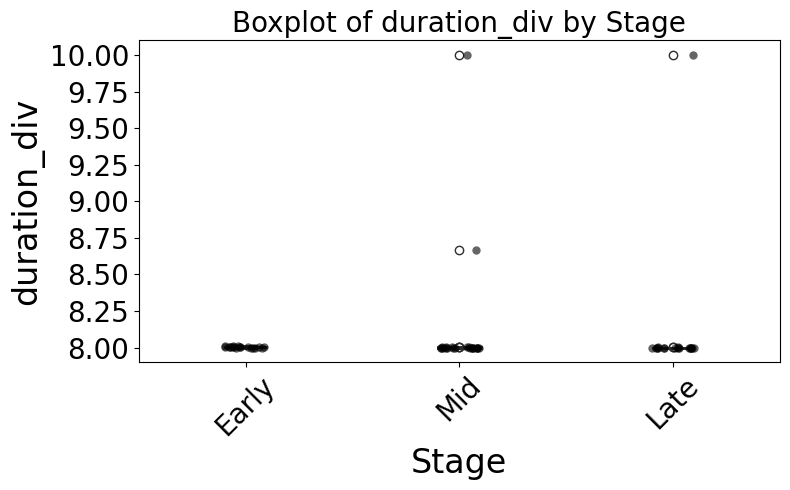

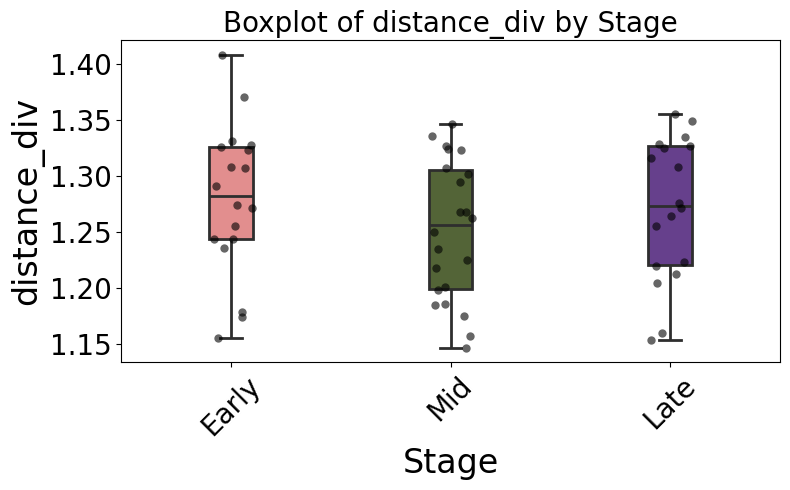

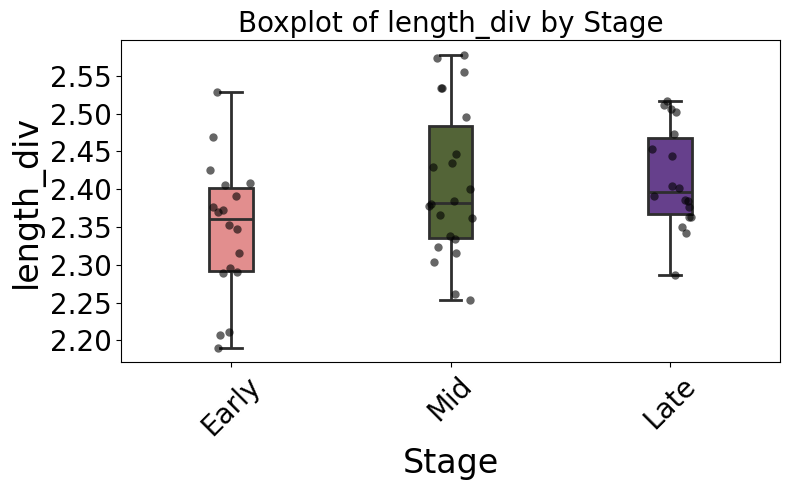

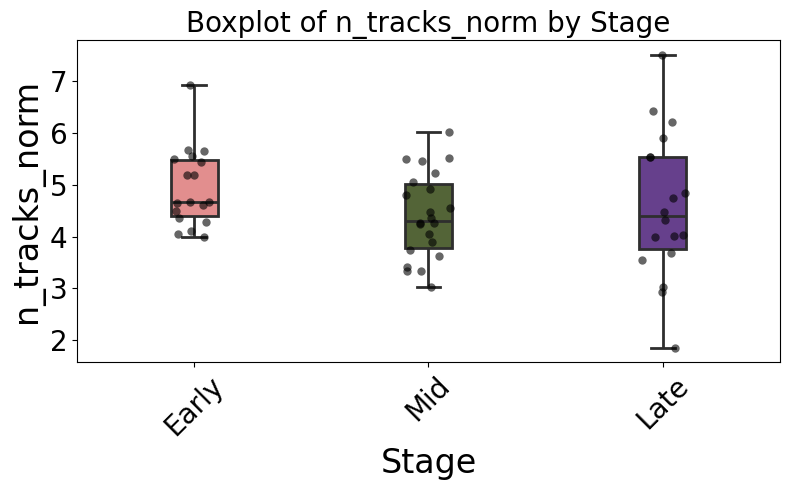

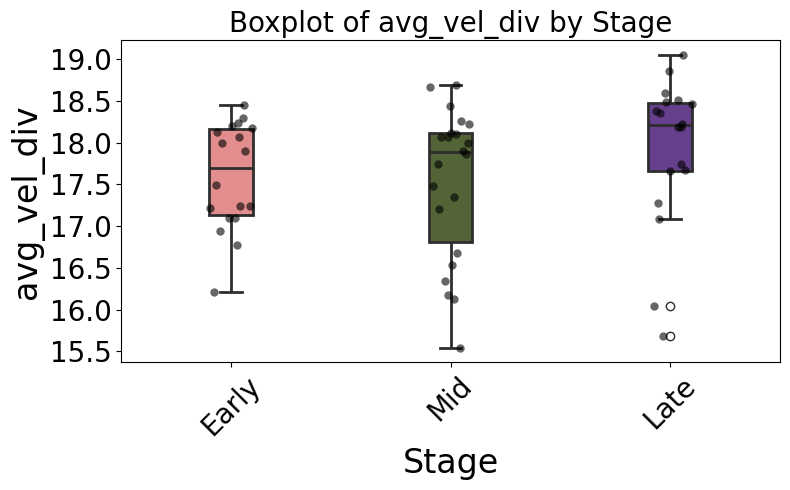

T-tests for duration_div:
Early vs Mid: p-value = 0.223792051882902
Early vs Late: p-value = 0.34330973193348147
Mid vs Late: p-value = 0.945340976621035
T-tests for distance_div:
Early vs Mid: p-value = 0.19240968277404238
Early vs Late: p-value = 0.7204884355103502
Mid vs Late: p-value = 0.3342628634706284
T-tests for length_div:
Early vs Mid: p-value = 0.0481980906429302
Early vs Late: p-value = 0.016309143569595945
Mid vs Late: p-value = 0.826324424821381
T-tests for n_tracks_norm:
Early vs Mid: p-value = 0.04057180737220993
Early vs Late: p-value = 0.3564850860491878
Mid vs Late: p-value = 0.6396588459420968
T-tests for avg_vel_div:
Early vs Mid: p-value = 0.7659692648269355
Early vs Late: p-value = 0.23811014501461242
Mid vs Late: p-value = 0.18550247120089813


In [22]:
# # Load results dataframes for each stage (adjust the paths as necessary)
# results_early_stage = pd.read_csv(convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\early_stage_results.csv'))
# results_mid_stage = pd.read_csv(convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\mid_stage_results.csv'))
# results_late_stage = pd.read_csv(convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\late_stage_results.csv'))

# # Combine the results into a single DataFrame for plotting
# results_combined = pd.concat([
#     results_early_stage.assign(Stage='Early'),
#     results_mid_stage.assign(Stage='Mid'),
#     results_late_stage.assign(Stage='Late')
# ])

# # List of metrics to plot
# metrics = ['duration_div', 'distance_div', 'length_div', 'n_tracks_norm', 'inst_vel_div', 'avg_vel_div']
# results_ttests = {}

# # Define colors for each stage
# stage_colors = {
#     'Early': 'lightcoral',
#     'Mid': 'darkolivegreen',
#     'Late': 'rebeccapurple'
# }

# # Create separate figures for each metric
# for metric in metrics:
#     plt.figure(figsize=(8, 5))
    
#     # Create boxplot with narrower boxes and bolder outlines
#     sns.boxplot(data=results_combined, x='Stage', y=metric, width=0.2,  
#                 palette=stage_colors, linewidth=2)

#     # Overlay scatter points with increased size
#     sns.stripplot(data=results_combined, x='Stage', y=metric, color='black', 
#                   alpha=0.6, size=6)

#     # Customize the plot
#     plt.title(f'Boxplot of {metric} by Stage', fontsize=20)
#     plt.xlabel('Stage', fontsize=24)
#     plt.ylabel(metric, fontsize=24)
#     plt.xticks(rotation=45, fontsize=20)
#     plt.yticks(fontsize=20)
#     plt.tight_layout()

#     # Save the figure as an SVG file with high DPI
#     plt.savefig(f'{metric}_boxplot.svg', dpi=300)
#     plt.show()

#     # Perform t-tests between stages for the current metric
#     early_values = results_early_stage[metric].dropna()
#     mid_values = results_mid_stage[metric].dropna()
#     late_values = results_late_stage[metric].dropna()

#     ttest_results = {
#         'Early vs Mid': stats.ttest_ind(early_values, mid_values, equal_var=False),
#         'Early vs Late': stats.ttest_ind(early_values, late_values, equal_var=False),
#         'Mid vs Late': stats.ttest_ind(mid_values, late_values, equal_var=False)
#     }
    
#     results_ttests[metric] = ttest_results

# # Optionally print t-test results for inspection
# for metric, tests in results_ttests.items():
#     print(f'T-tests for {metric}:')
#     for comparison, result in tests.items():
#         print(f'{comparison}: p-value = {result.pvalue}')


In [67]:

# Load results dataframes for each stage and pixel threshold
results_early_3px = pd.read_csv(convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\early_stage_results_above_3px.csv'))
results_mid_3px = pd.read_csv(convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\mid_stage_results_above_3px.csv'))
results_late_3px = pd.read_csv(convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\late_stage_results_above_3px.csv'))

results_early_6px = pd.read_csv(convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\early_stage_results_above_6px.csv'))
results_mid_6px = pd.read_csv(convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\mid_stage_results_above_6px.csv'))
results_late_6px = pd.read_csv(convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\late_stage_results_above_6px.csv'))

results_early_9px = pd.read_csv(convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\early_stage_results_above_9px.csv'))
results_mid_9px = pd.read_csv(convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\mid_stage_results_above_9px.csv'))
results_late_9px = pd.read_csv(convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\late_stage_results_above_9px.csv'))

# Combine the results into a single DataFrame for each pixel threshold for plotting
results_combined_3px = pd.concat([
    results_early_3px.assign(Stage='Early'),
    results_mid_3px.assign(Stage='Mid'),
    results_late_3px.assign(Stage='Late')
])

results_combined_6px = pd.concat([
    results_early_6px.assign(Stage='Early'),
    results_mid_6px.assign(Stage='Mid'),
    results_late_6px.assign(Stage='Late')
])

results_combined_9px = pd.concat([
    results_early_9px.assign(Stage='Early'),
    results_mid_9px.assign(Stage='Mid'),
    results_late_9px.assign(Stage='Late')
])

# Define metrics to plot
metrics = ['duration_div', 'distance_div', 'length_div', 'n_tracks_norm', 'avg_vel_div', 'inst_vel_div']

# Define colors for each stage
stage_colors = {
    'Early': 'lightcoral',
    'Mid': 'lightgreen',
    'Late': 'plum'
}

# Initialize dictionary to store statistical test results for each metric
results_tests = {}

# # Helper function to check normality, plot, and perform ANOVA/Kruskal-Wallis test
# def plot_and_test(results_combined, pixel_threshold):
#     for metric in metrics:
#         plt.figure(figsize=(8, 5))
        
#         # Create boxplot with narrower boxes and bolder outlines
#         sns.boxplot(data=results_combined, x='Stage', y=metric, width=0.2,  
#                     palette=stage_colors, linewidth=2)

#         # Overlay scatter points with a different border color (e.g., 'blue') and black fill
#         sns.stripplot(data=results_combined, x='Stage', y=metric, facecolor='none', 
#               alpha=0.8, size=6, edgecolor='black', linewidth=1.5, jitter=False, dodge=True,)

#         # Customize the plot
#         plt.title(f'Boxplot of {metric} by Stage (> {pixel_threshold}px)', fontsize=20)
#         plt.xlabel('Stage', fontsize=24)
#         plt.ylabel(metric, fontsize=24)
#         plt.xticks(rotation=45, fontsize=20)
#         plt.yticks(fontsize=20)
#         plt.tight_layout()

#         # Save the figure as an SVG file with high DPI
#         plt.savefig(f'{metric}_boxplot_above_{pixel_threshold}px.svg', dpi=300)
#         plt.show()

#         # Extract values for each stage and drop missing values
#         early_values = results_combined[results_combined['Stage'] == 'Early'][metric].dropna()
#         mid_values = results_combined[results_combined['Stage'] == 'Mid'][metric].dropna()
#         late_values = results_combined[results_combined['Stage'] == 'Late'][metric].dropna()

#         # Check normality for each stage
#         _, p_early = shapiro(early_values)
#         _, p_mid = shapiro(mid_values)
#         _, p_late = shapiro(late_values)

#         # Perform ANOVA if all stages follow normality, otherwise perform Kruskal-Wallis test
#         if p_early > 0.05 and p_mid > 0.05 and p_late > 0.05:
#             test_result = f_oneway(early_values, mid_values, late_values)
#             test_type = 'ANOVA'
#         else:
#             test_result = kruskal(early_values, mid_values, late_values)
#             test_type = 'Kruskal-Wallis'

#         # Store the test result
#         results_tests[f'{metric}_above_{pixel_threshold}px'] = {'test_type': test_type, 'p_value': test_result.pvalue}

# # Plot and perform tests for each pixel threshold
# plot_and_test(results_combined_3px, 3)
# plot_and_test(results_combined_6px, 6)
# plot_and_test(results_combined_9px, 9)

# # Optionally, print test results for inspection
# for metric, result in results_tests.items():
#     print(f'{result["test_type"]} for {metric}: p-value = {result["p_value"]}')


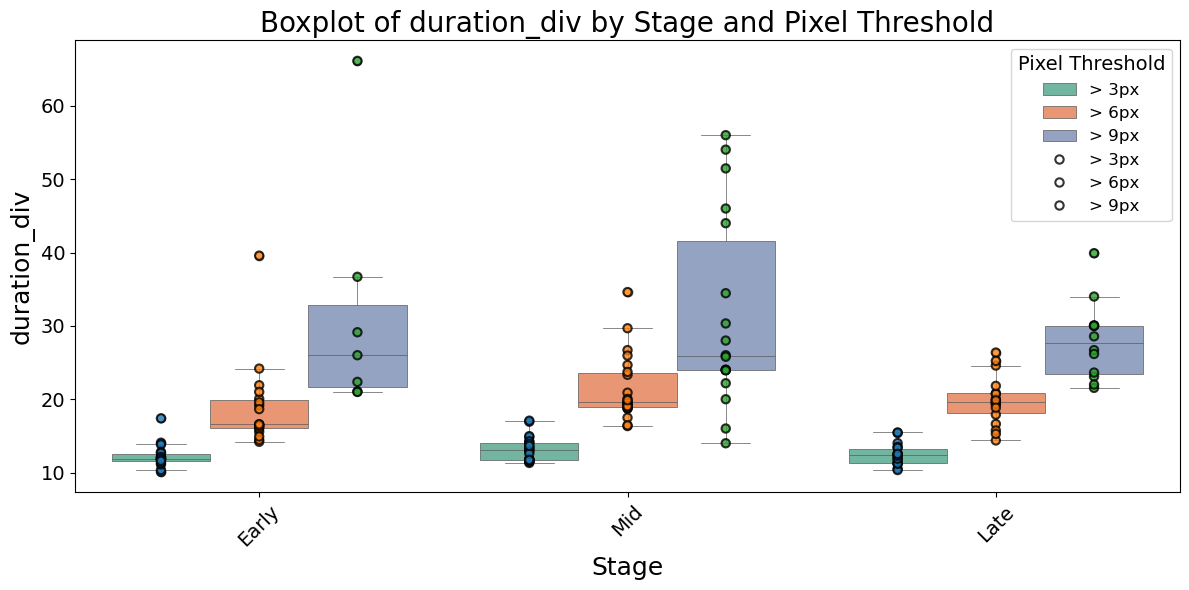

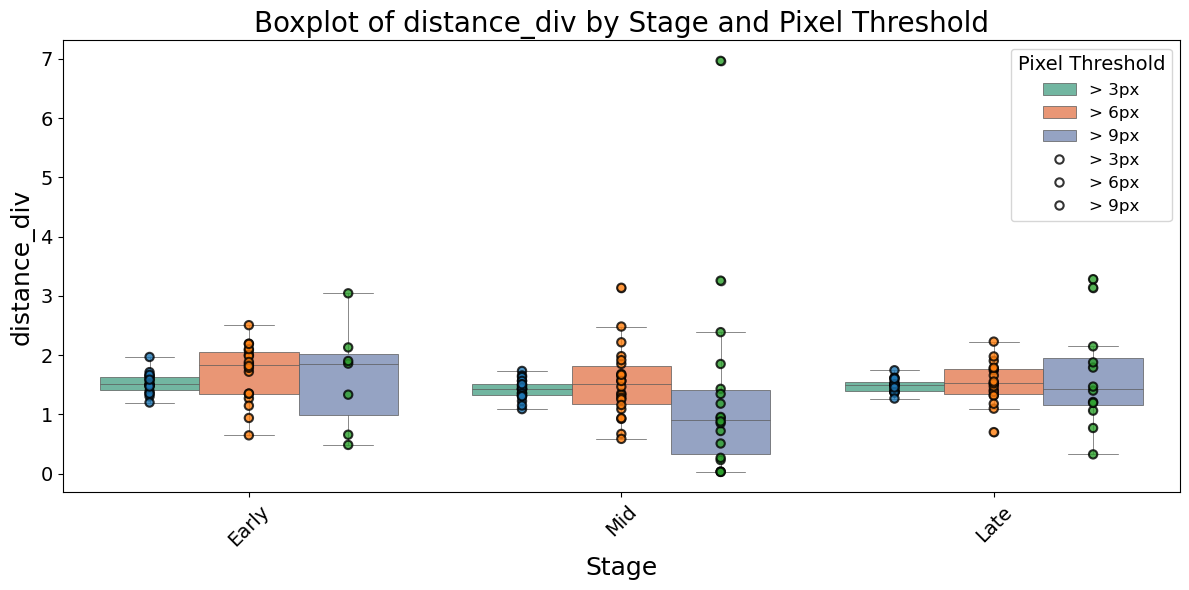

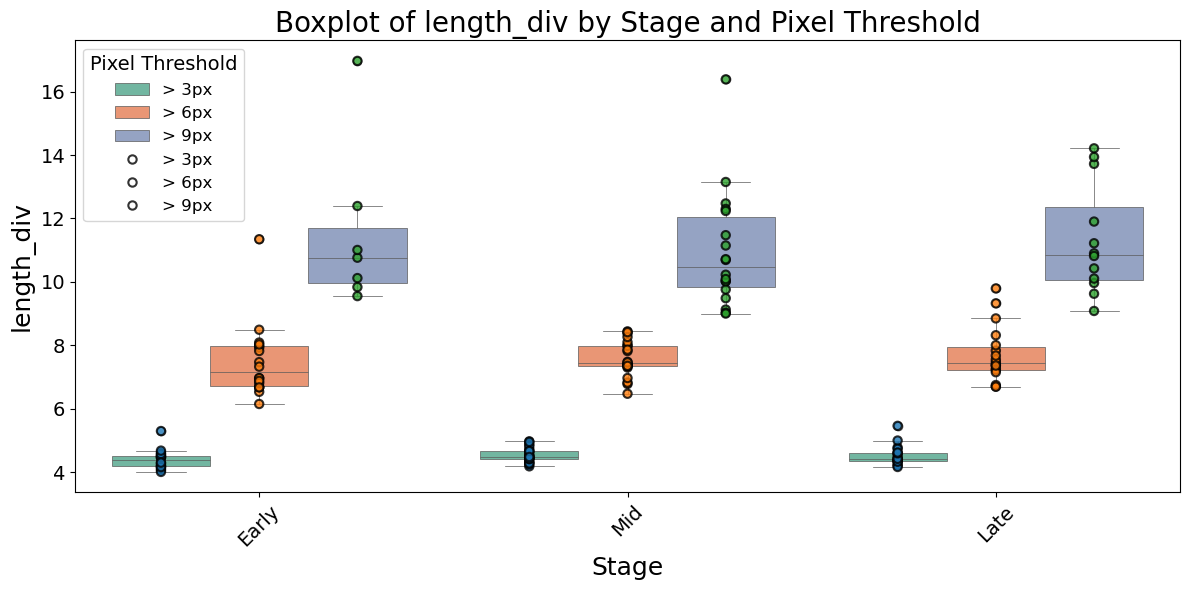

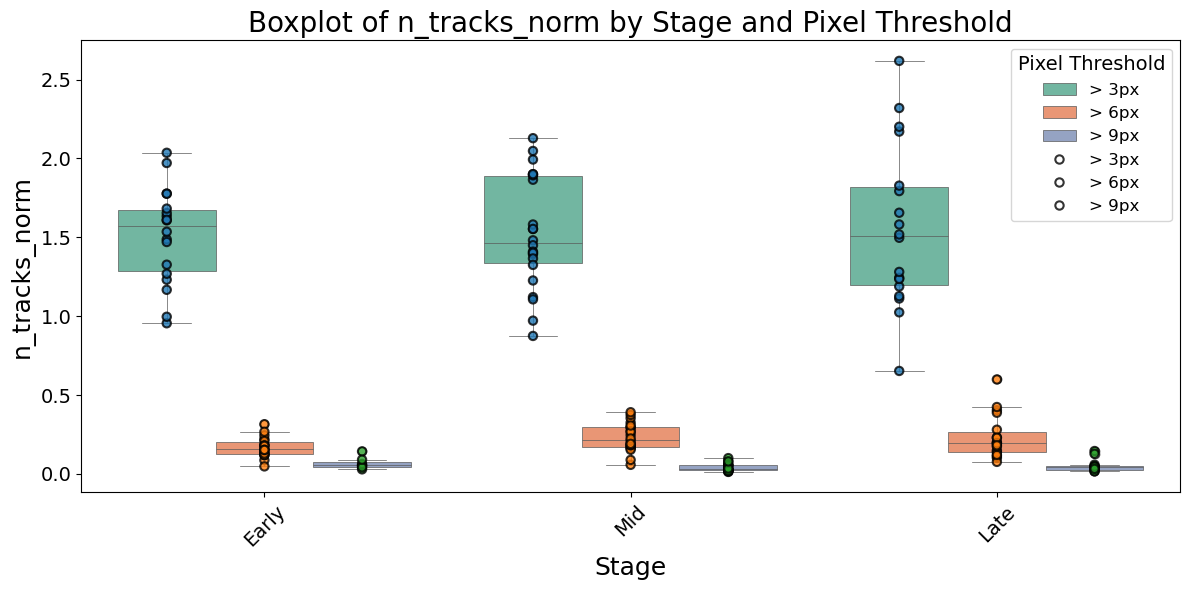

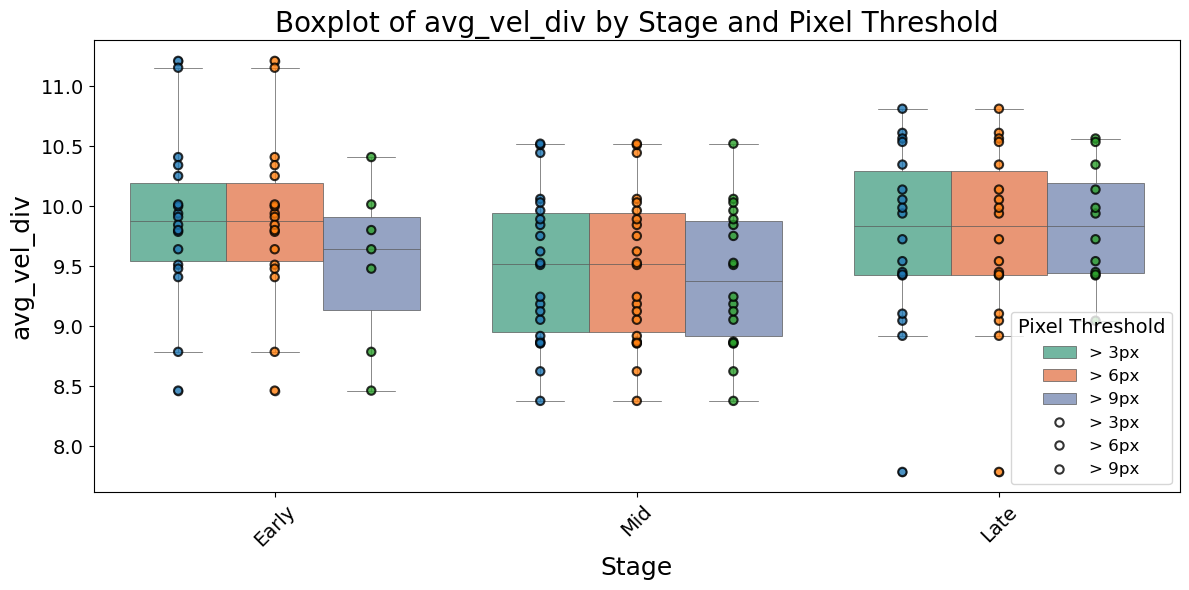

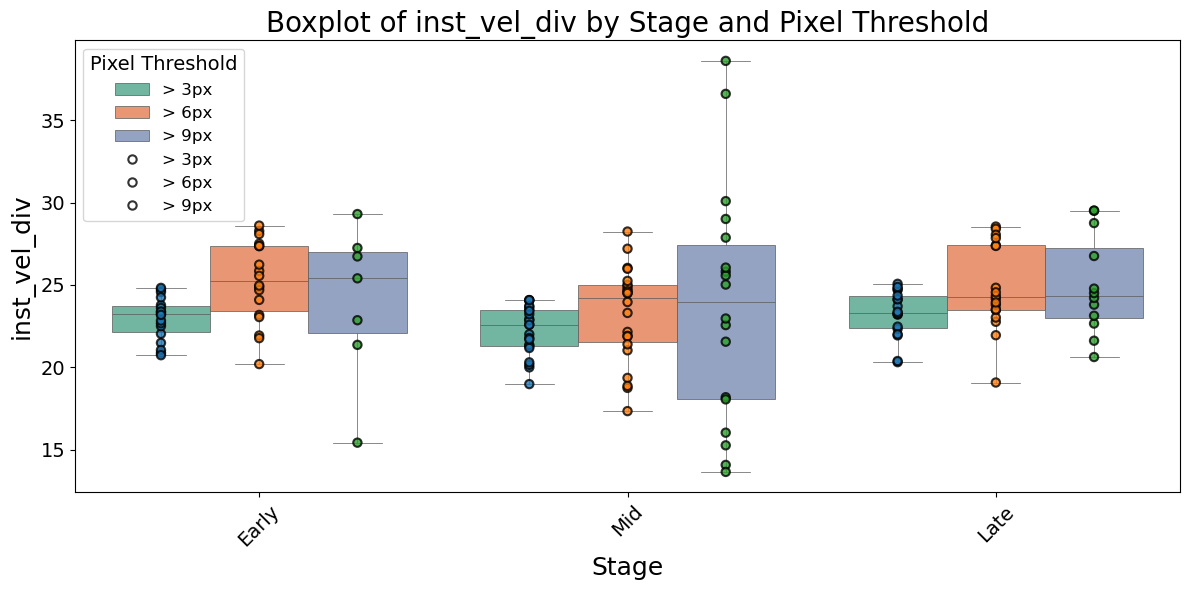

In [70]:
def plot_and_test_combined(results_combined_3px, results_combined_6px, results_combined_9px):
    # Add a new column for pixel threshold
    results_combined_3px['Pixel_Threshold'] = '> 3px'
    results_combined_6px['Pixel_Threshold'] = '> 6px'
    results_combined_9px['Pixel_Threshold'] = '> 9px'

    # Combine all data into one DataFrame
    results_combined_all = pd.concat([results_combined_3px, results_combined_6px, results_combined_9px])

    for metric in metrics:
        plt.figure(figsize=(12, 6))

        # Create boxplot with hue for pixel thresholds
        sns.boxplot(data=results_combined_all, x='Stage', y=metric, hue='Pixel_Threshold', 
                    palette='Set2', linewidth=.5)

        # Overlay scatter points with no fill, consistent edge color, and no jitter
        sns.stripplot(data=results_combined_all, x='Stage', y=metric, hue='Pixel_Threshold', 
                      dodge=True, facecolor='none', edgecolor='black', alpha=0.8, size=6, jitter=False, linewidth=1.5)

        # Customize the plot
        plt.title(f'Boxplot of {metric} by Stage and Pixel Threshold', fontsize=20)
        plt.xlabel('Stage', fontsize=18)
        plt.ylabel(metric, fontsize=18)
        plt.xticks(rotation=45, fontsize=14)
        plt.yticks(fontsize=14)
        plt.legend(title='Pixel Threshold', fontsize=12, title_fontsize=14)
        plt.tight_layout()

        # Save the figure as an SVG file with high DPI
        plt.savefig(f'{metric}_boxplot_combined.svg', dpi=300)
        plt.show()

# Plot and perform tests for each pixel threshold
plot_and_test_combined(results_combined_3px, results_combined_6px, results_combined_9px)


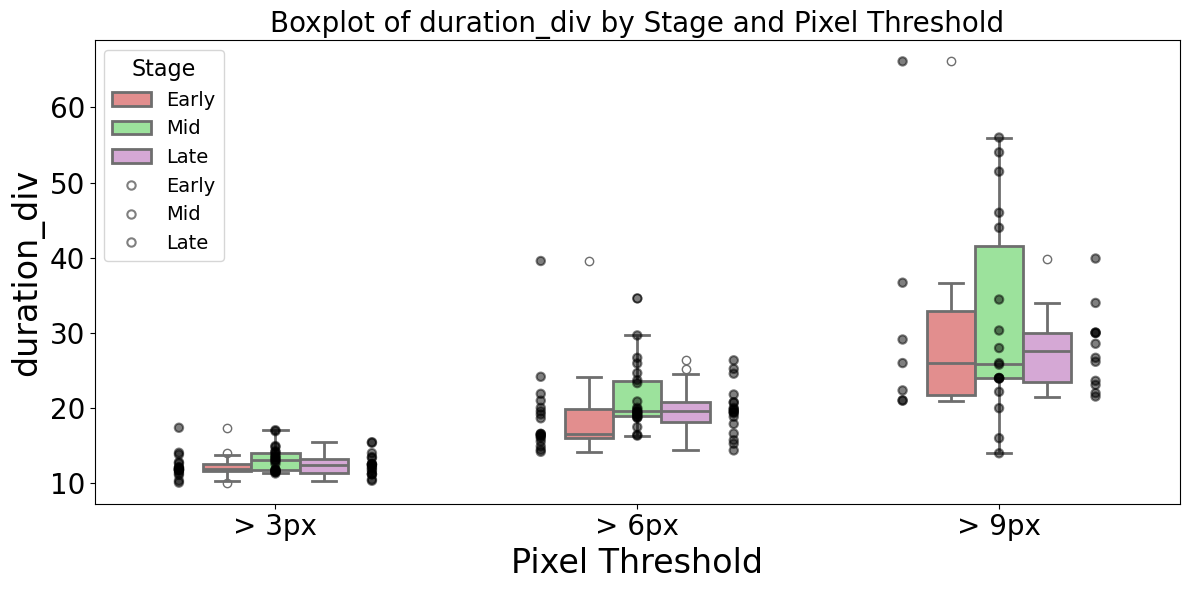

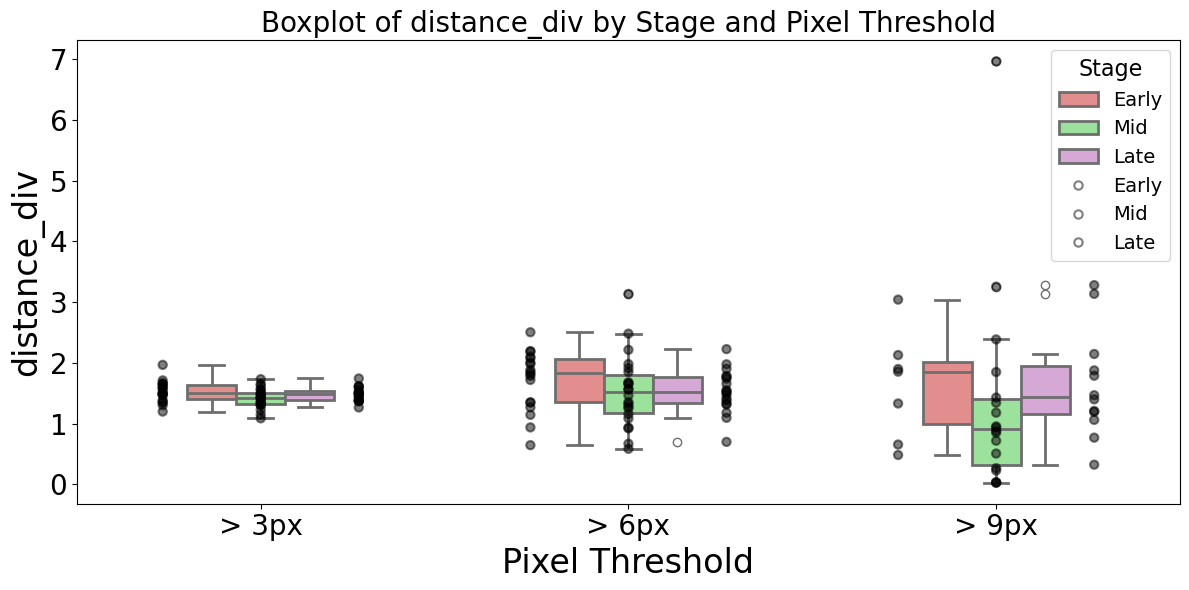

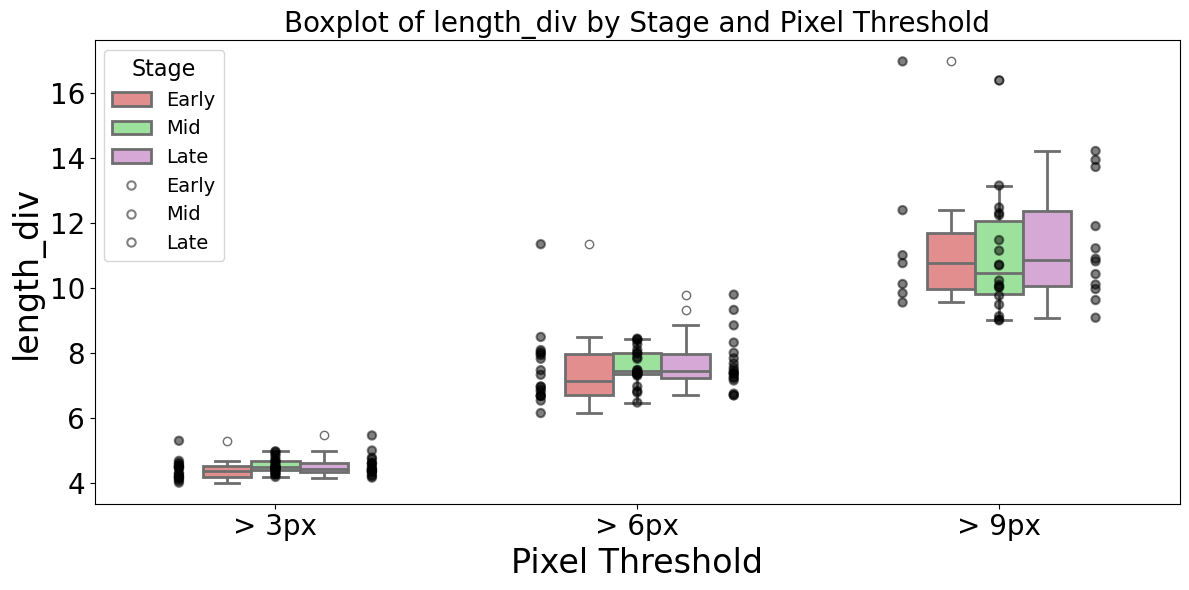

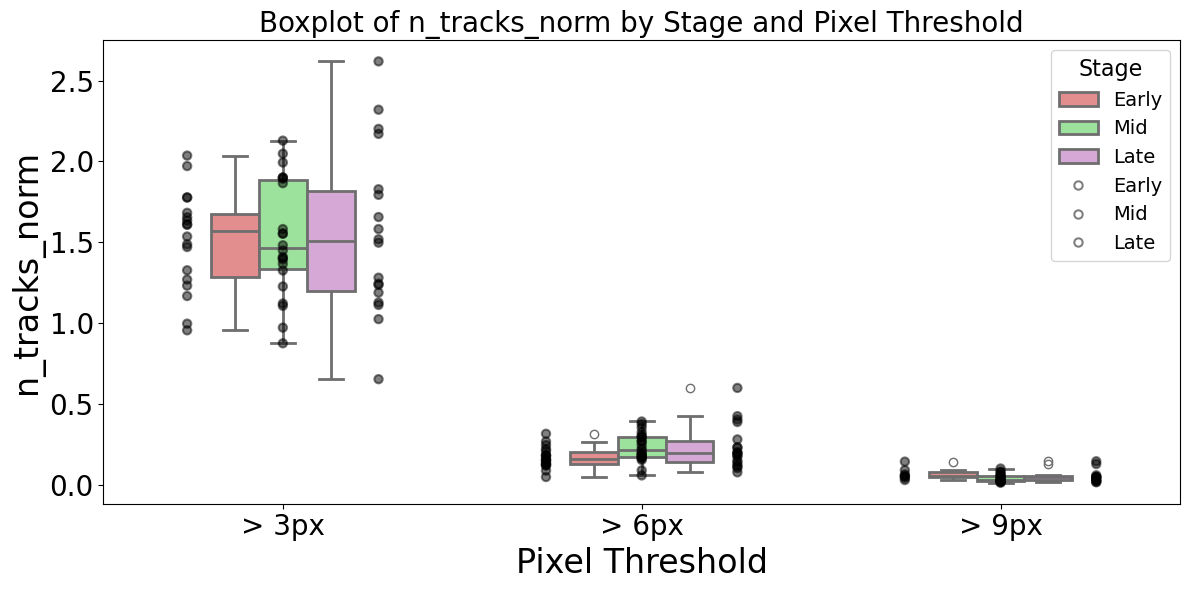

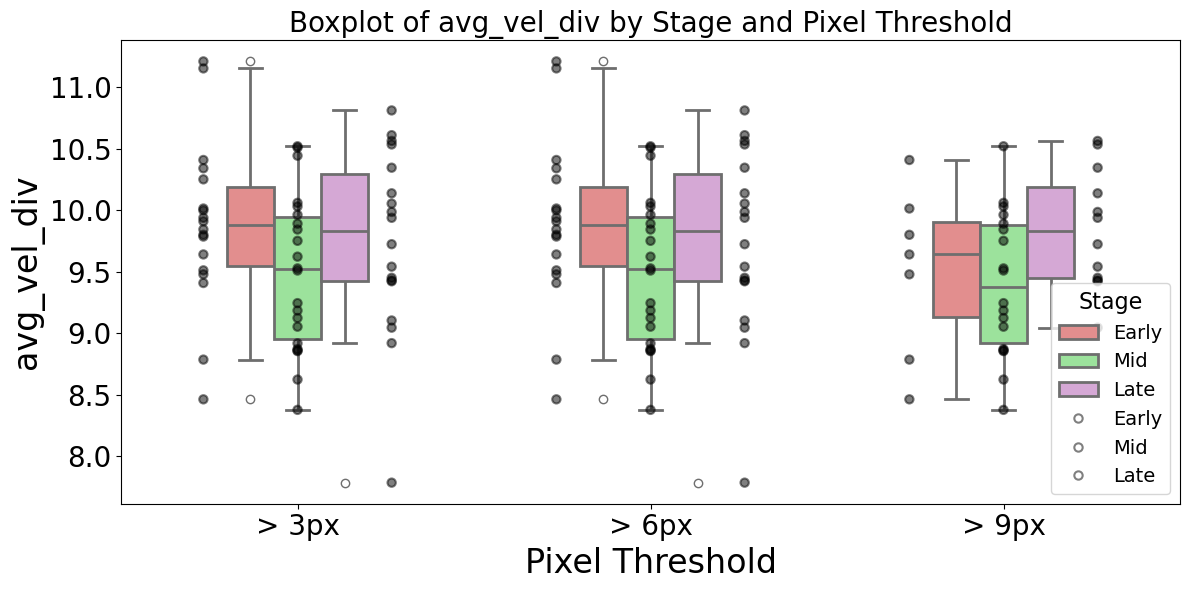

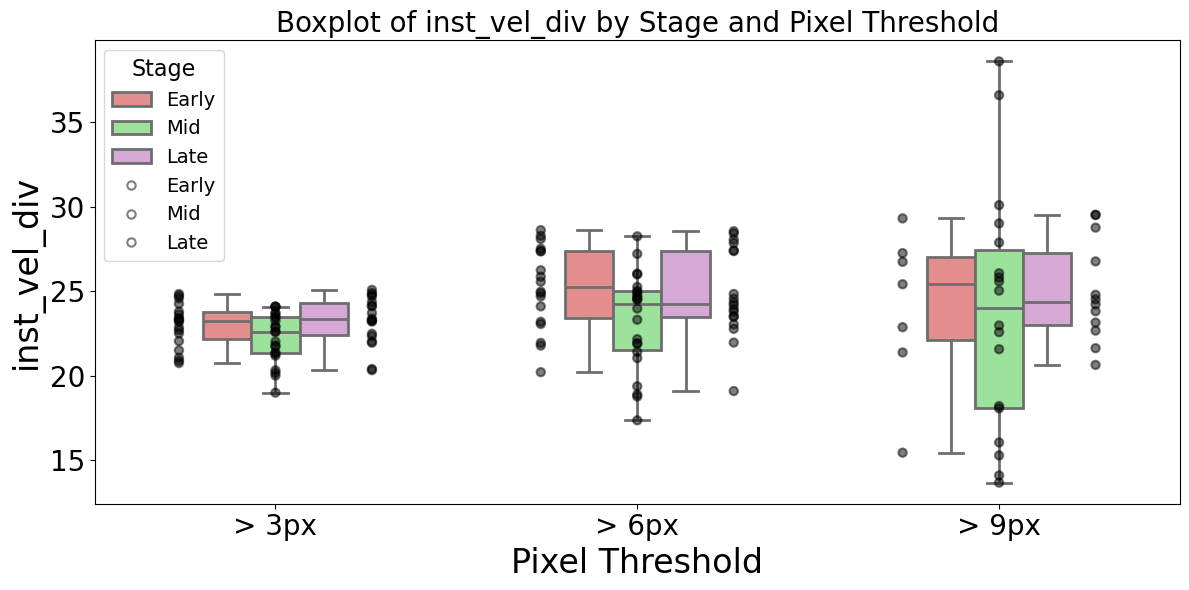

In [84]:
def plot_and_test_combined(results_combined_3px, results_combined_6px, results_combined_9px):
    # Add a 'Threshold' column to each DataFrame
    results_combined_3px['Threshold'] = '> 3px'
    results_combined_6px['Threshold'] = '> 6px'
    results_combined_9px['Threshold'] = '> 9px'

    # Concatenate all the results
    results_combined = pd.concat([results_combined_3px, results_combined_6px, results_combined_9px])

    for metric in metrics:
        plt.figure(figsize=(12, 6))

        # Create boxplot for all thresholds and stages together
        sns.boxplot(data=results_combined, x='Threshold', y=metric, hue='Stage', 
                    palette=stage_colors, linewidth=2, width=0.4)

        # Overlay scatter points for all thresholds
        sns.stripplot(data=results_combined, x='Threshold', y=metric, hue='Stage', 
                      palette=['black']*3, dodge=True, facecolor='none', edgecolor='black', alpha=0.5, size=6, jitter=False, linewidth=1.5)

        # Customize the plot
        plt.title(f'Boxplot of {metric} by Stage and Pixel Threshold', fontsize=20)
        plt.xlabel('Pixel Threshold', fontsize=24)
        plt.ylabel(metric, fontsize=24)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)

        # Improve the legend and tight layout
        plt.legend(title='Stage', fontsize=14, title_fontsize=16)
        plt.tight_layout()

        # Save the figure as an SVG file with high DPI
        plt.savefig(f'{metric}_boxplot_combined_thresholds.svg', dpi=300)
        plt.show()

# Call the function for combined plots
plot_and_test_combined(results_combined_3px, results_combined_6px, results_combined_9px)



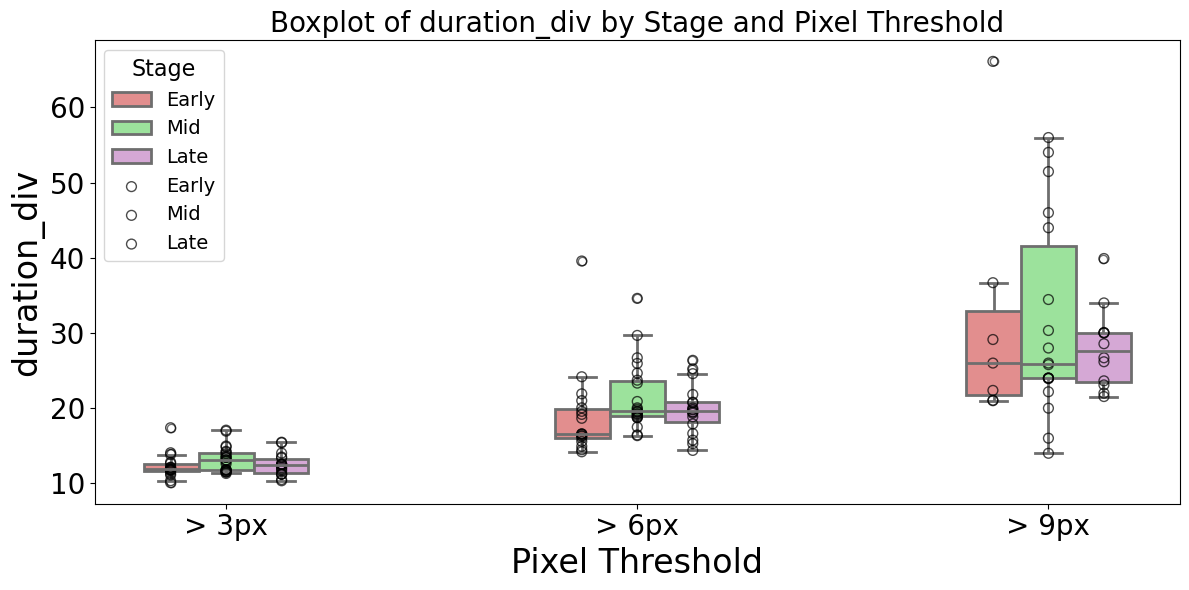

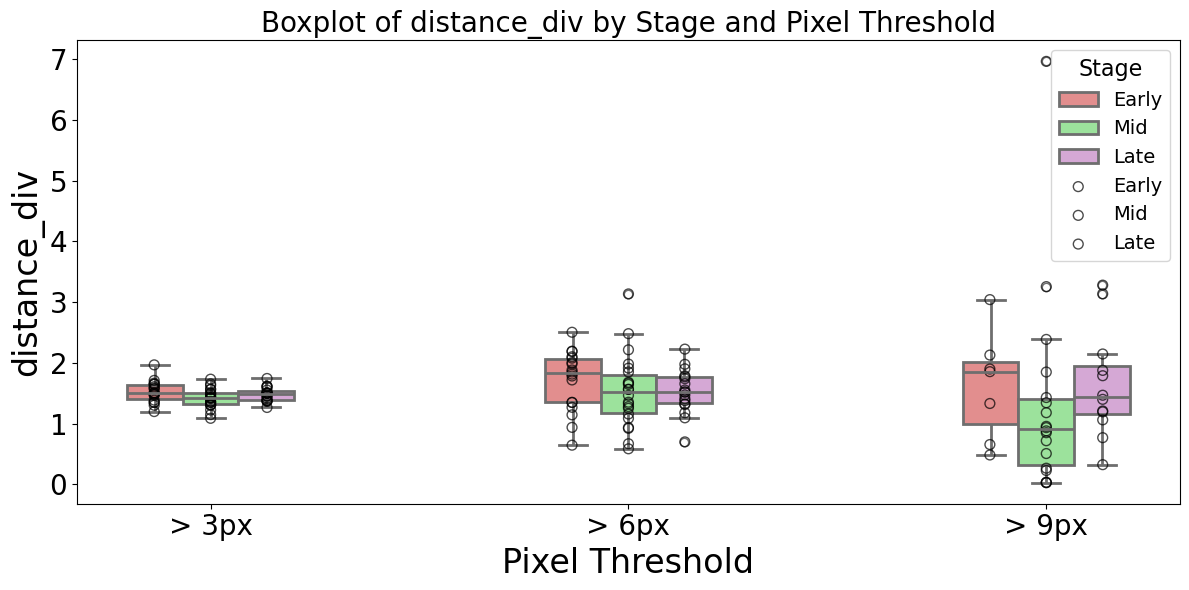

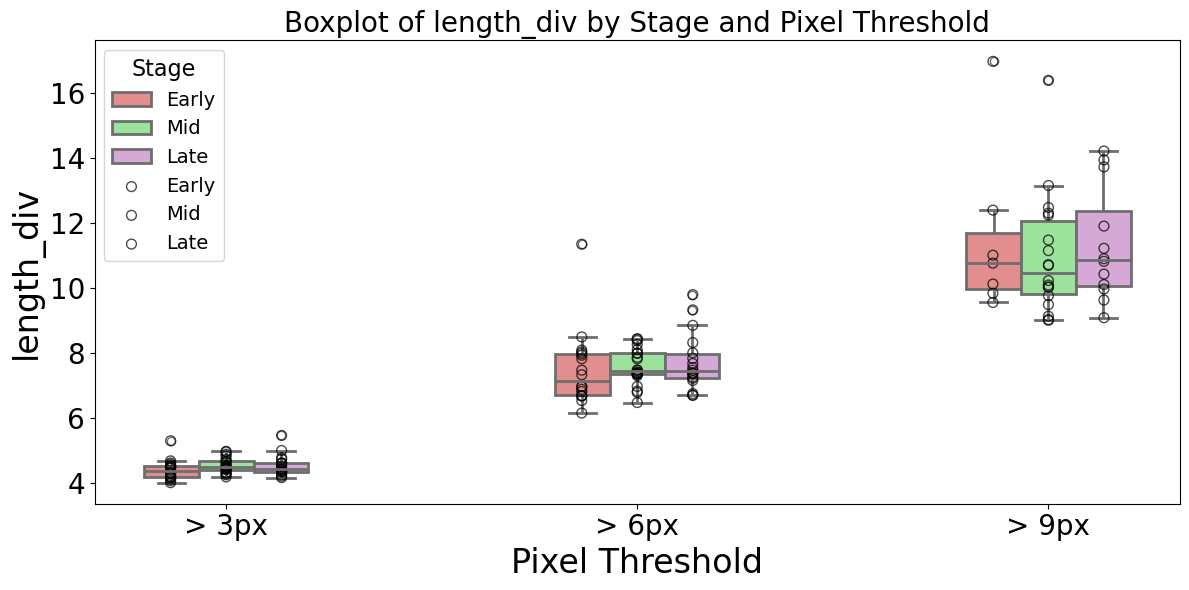

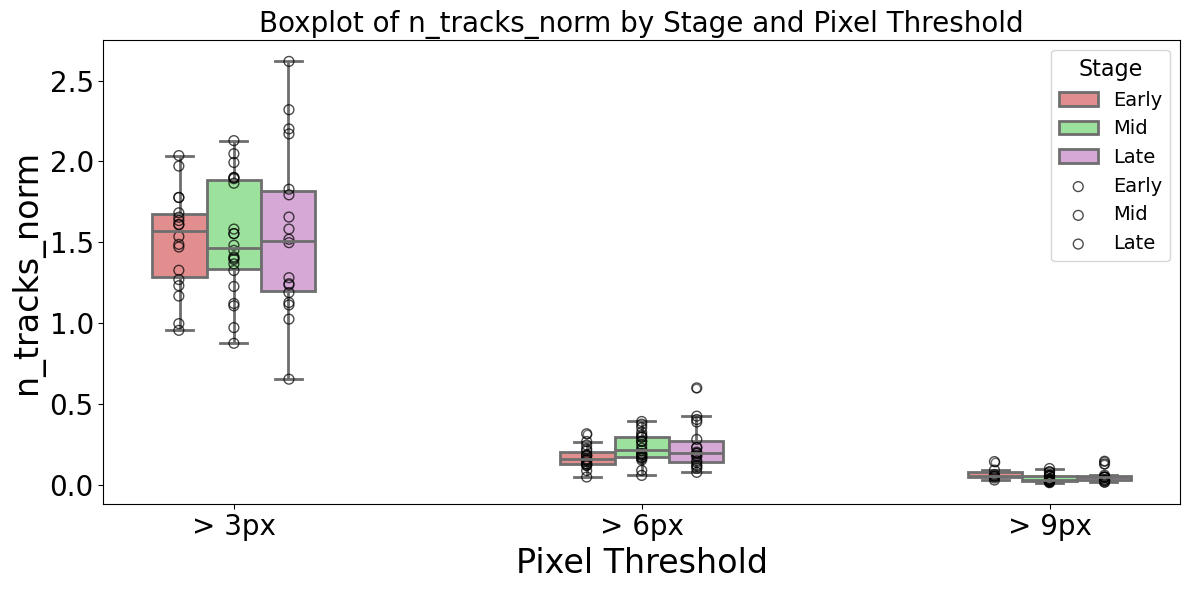

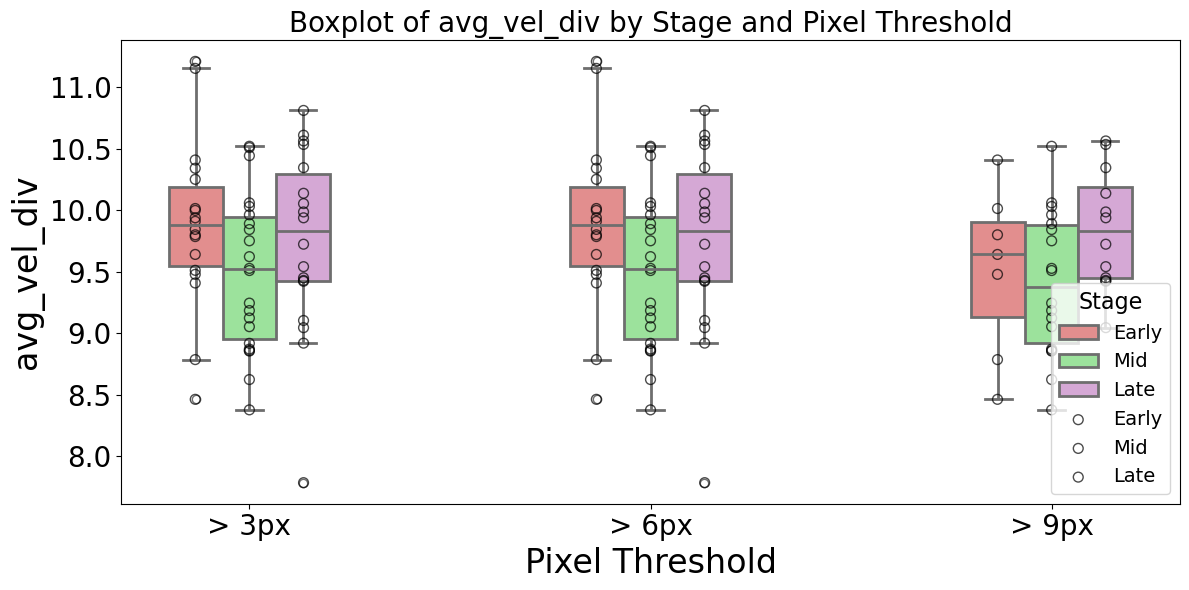

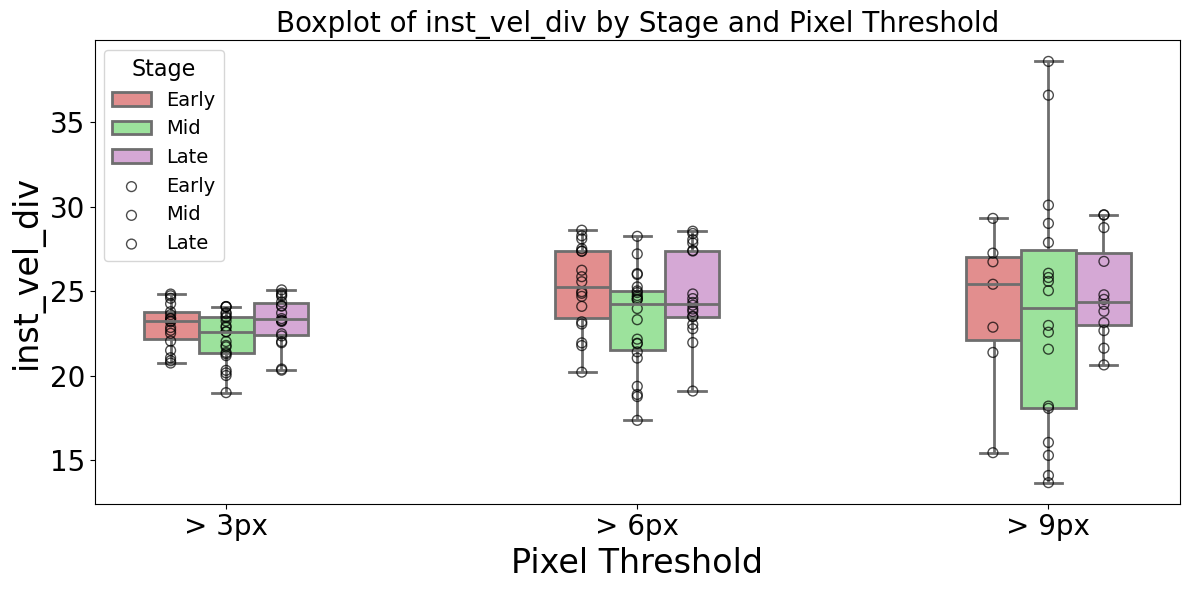

In [89]:
def plot_and_test_combined(results_combined_3px, results_combined_6px, results_combined_9px):
    # Add a 'Threshold' column to each DataFrame
    results_combined_3px['Threshold'] = '> 3px'
    results_combined_6px['Threshold'] = '> 6px'
    results_combined_9px['Threshold'] = '> 9px'

    # Concatenate all the results
    results_combined = pd.concat([results_combined_3px, results_combined_6px, results_combined_9px])

    for metric in metrics:
        plt.figure(figsize=(12, 6))

        # Create boxplot for all thresholds and stages together
        sns.boxplot(data=results_combined, x='Threshold', y=metric, hue='Stage', 
                    palette=stage_colors, linewidth=2, width=0.4)

        # Set up manual offsets to align scatter points
        offsets = {'Early': -0.135, 'Mid': 0, 'Late': 0.135}
        
        # Overlay scatter points for each combination of stage and threshold
        for stage, offset in offsets.items():
            for i, threshold in enumerate(['> 3px', '> 6px', '> 9px']):
                # Filter data for this stage and threshold
                data_subset = results_combined[(results_combined['Stage'] == stage) &
                                               (results_combined['Threshold'] == threshold)]
                # Calculate the x-position for scatter points
                x_positions = np.full(len(data_subset), i + offset)
                
                # Overlay scatter points for each stage and threshold
                plt.scatter(x=x_positions, y=data_subset[metric], 
                            edgecolor='black', facecolor='none', s=50, alpha=0.7, 
                            label=stage if i == 0 else "", zorder=2)

        # Customize the plot
        plt.title(f'Boxplot of {metric} by Stage and Pixel Threshold', fontsize=20)
        plt.xlabel('Pixel Threshold', fontsize=24)
        plt.ylabel(metric, fontsize=24)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)

        # Improve the legend and tight layout
        plt.legend(title='Stage', fontsize=14, title_fontsize=16)
        plt.tight_layout()

        # Save the figure as an SVG file with high DPI
        plt.savefig(f'{metric}_boxplot_combined_thresholds.svg', dpi=300)
        plt.show()

# Call the function for combined plots
plot_and_test_combined(results_combined_3px, results_combined_6px, results_combined_9px)
